## MSDS 432 - Programming Assignment #3 Dan Avni

## Executive Summary

The purpose of this exercise is to investigate the runtime performance of two solution implementations of the same problem– the factorial. The first solution is an iterative solution that loops over the numbers in the range 1..n to compute factorial(n), while the second solution is a recursive function that provides the same outcome by making n number of nested function calls.
Both solutions should share the expected Big O notation runtime performance as they perform the same number of operations. That Big O notation of runtime performance depends on the actual implementation of big integer multiplication. If an efficient method such as the Schönhage–Strassen algorithm is used, we excpect an O(n log n log log n)  runtime performance.

Reference: https://en.wikipedia.org/wiki/Sch%C3%B6nhage%E2%80%93Strassen_algorithm .


## Method and Conclusions

We demonstrate below that the despite the two implementations sharing the same Big O notation runtime, the recursive implementation is significantly slower and likely more resource consuming.
As the integer value analyzed grows, the depth of the recursion call incurs penalty in stack size required for state management while the iterative solution carries no overhead beyond the multiplication operation. 
While recursion has an important place in real-world implementations for east of coding and maintenance we should take care not to use recursion in scenarios that require tight runtime performance consideration or where the depth of the recursion is not reasonably controlled. 

See below chart of runtime performance against an array of 10 random integers between 100 and 500:

<img src="./runtime1.png">

## Implementation

In [13]:
#import required packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random

In [15]:
# recursuve facorial implemntation adapted retrieved from:
# https://github.com/egonSchiele/grokking_algorithms/blob/master/02_selection_sort/python/01_selection_sort.py

def recursive_fact(x):
  if x == 1:
    return 1
  else:
    return x * recursive_fact(x-1)

In [16]:
# iterative factorial solution u

def iterative_fact(x):
  fact = 1
  for i in range(1,x+1):
    fact = fact * i
  return fact

In [17]:
#unit test validation of the factorial implementation

print(recursive_fact(7))
print(iterative_fact(7))
print(recursive_fact(7)==iterative_fact(7))

5040
5040
True


In [18]:
#utility function to generate and array of uniformly distributed data array with persistent seed across calls 
def generate_random_array(item_count, low, high):
    np.random.seed(666)
    
    return np.random.randint(low, high, item_count).tolist()

In [19]:
#prepare an array of all the desired data lengths
random_ints = np.sort(generate_random_array(10, 100, 500)).tolist()

#prepare an empty data frame with the desired column names
test_data_col_names = ['number', 'factorial', 'iterative_ms', 'recursive_ms']
test_data = pd.DataFrame(columns = test_data_col_names) 

In [20]:
#iterate over the possible lens, create test data for each length, and compture runtime length in milliseconds
for random_int in random_ints:
    start   = time.time()
    fact1   = iterative_fact(random_int)
    iterative_ms = (time.time() - start) * 1000

    start   = time.time()
    fact2    = recursive_fact(random_int)
    recursive_ms = (time.time() - start) * 1000
    
    if fact1 != fact2:
        raise Exception('This should never have happened. The two methods should concur!')
    
    #insert the results into a new dataframe record 
    #need to cast the factorial into a string to prevent a pandas float or int overflow
    test_data.loc[len(test_data)] = [random_int, str(fact1), iterative_ms, recursive_ms]

Below is a tabular representation of the test data. It is useful as the charts fail to show the minute fluctuations in the binary search performance. To get a true read of the binary search performance we will need to run multiple tests and average the results, as well as increase the size. We should also try to execute the code in a virtualized environment where the CPU is under competition from other processes.

In [21]:
#plain text data dump of the test results
test_data

,number,factorial,iterative_ms,recursive_ms
0,151,8627209774233240431623188626544191544816225903...,0.036478,0.211477
1,160,4714723635992061322406943211761943779511926230...,0.145197,0.227928
2,170,7257415615307998967396728211129263114716991681...,0.026226,0.174522
3,191,1848941630973752588819559184291528260234868800...,0.029087,0.153542
4,256,8578177753428426541190822716812326251577815202...,0.099421,1.531839
5,322,2187246741752763751432688247998659781970331487...,0.054121,0.334024
6,323,7064806975861426917127583041035671095764170704...,0.109196,0.179529
7,336,3885246413919554674957188781709166666213058911...,0.088215,0.230789
8,418,6704355013599149103015045905466432364040846480...,0.097513,1.282215
9,486,2402100606040589897197638086812797478301774839...,0.094175,1.405001


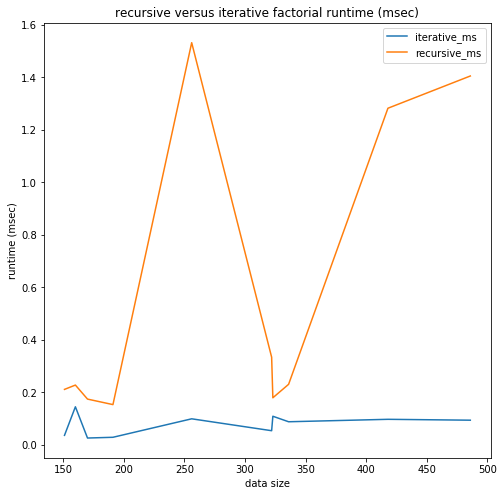

In [22]:
#plot the binary and linear search results against the data length
plt.figure(figsize=(8,8))

plt.plot(test_data.number, test_data.iterative_ms)
plt.plot(test_data.number, test_data.recursive_ms)

plt.legend()
plt.xlabel('data size')
plt.ylabel('runtime (msec)')
plt.title('recursive versus iterative factorial runtime (msec)')
plt.show()

## Extra Credit

A recursive version of factorial using tail recursion can eliminate the recursion depth limitation set by Python. Alas, Python, unlike other functional langauges does not offer tail recursion optimization that prevents stack overflow by maintaining a fixed stack size - tail recursion only requires the last stack information to be preserved.

The below solution is adapted to Python 3 from the ingenious "hack" presented here:
http://code.activestate.com/recipes/474088/

The solution works by decorating the function call with a wrapper that raises and catches an exception calls that unwinds the stack and retains only the requires information.

In [46]:
import sys
print(sys.getrecursionlimit())
#current limit is 3000

3000


In [47]:
recursive_fact(3001) 
# demonsrte the original call fails with exception

RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
class TailRecurseException(BaseException):
  def __init__(self, args, kwargs):
    self.args = args
    self.kwargs = kwargs

def tail_call_optimized(g):
  """
  This function decorates a function with tail call
  optimization. It does this by throwing an exception
  if it is it's own grandparent, and catching such
  exceptions to fake the tail call optimization.
  
  This function fails if the decorated
  function recurses in a non-tail context.
  """
  def func(*args, **kwargs):
    f = sys._getframe()
    if f.f_back and f.f_back.f_back \
        and f.f_back.f_back.f_code == f.f_code:
      raise TailRecurseException(args, kwargs)
    else:
      while 1:
        try:
          return g(*args, **kwargs)
        except TailRecurseException as err:
          args = err.args
          kwargs = err.kwargs
  func.__doc__ = g.__doc__
  return func

In [ ]:
@tail_call_optimized
def tail_factorial(n, acc=1):
    "calculate a factorial"
    if n == 0:
       return acc
    res = tail_factorial(n-1, n*acc)
    return res

In [48]:
print(tail_factorial(3001))

1245222816991700011075615814635292312502430870399036156298609244075037325393571938220808829641861882636456290907862349726057483642132517692914547598853660871744747347505017317437100528339292280982993238121854024962156440270574061141820593971160636224836183063741848006452281425766763400451040535788576215550636849104815789026404314582504082973870238839309296485553148882009291016424309413871846147705664411924540187722716871126267161598366854776303279015619805392266162529002144932461069780304039228434273259222085507697709367492939119713904829778931374685642903253341786105787091107509717585471293282035776139994471450253994746382108706199982518009085792117809100744163498616140773494063506924234753735489840283650189976886169883417899154571534467072440593499573688316375029664404704958870102704296901057260750828574330295520915832486355905089498266067150586725909058124424273897338920799633232831351962932357928580875045491695106285569246847509379402063963856397821610053242852014392585645079191060

A GitHub reposotory contaning commits for all the maerials in the assignemt was shared and made available here:

https://github.com/dannyavni/MSDS_432